In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cluster_tools
from cluster_tools import get_flatspots
#
import numpy
import scipy
import scipy.optimize
import sklearn
import sklearn.neighbors
import pylab as plt
import itertools
import random
#
import operator
import functools
import multiprocessing as mpp
#
import numpy
import math
import pylab as plt
import datetime as dtm
import time
#
import pandas

#TODO: move to yodiipy
import optimizers

def f_lin(x,a,b):
    return a + b*x

colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']


### sklearn Cluster Finder Development
- we developed a NN cluster finder in a previous project/workseheet
- sklearn has some built in cluster finding algoritmhs that might be useful and mabye a bit faster (largely because they're compiled, and folks have had more time to work on them).
- consider, instead of one optimized cluster-finder, a cascade of standard algorithms to dial in on a data-set.

- We might use some DDP data, but to start with, let's just use synthetic linear data, with a bit of noise


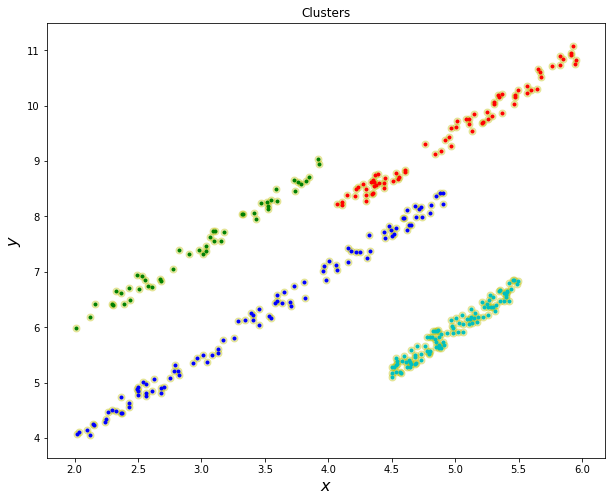

In [3]:
# to start with, make clusters with exactly the same slope; shift them around a bit
import random
#
R_x  = random.Random()
R_dy = random.Random()
sig_y = .2
#
b = 1.5
clusters_input = []
# [ [x0, x_max, b, y0, N], ... ]
prms = [[2., 5.,b, 1., 100], [2.,4., b, 3.,50], [4.,6.,b,2.,75], [4.5, 5.5,b,-1.5,100]]
#
for x0, x1,b,y0,N in prms:
    #pp = {key:val for key,val in zip(['x0', 'x1','b','y0','N'], prms)}
    #
    dx = x1-x0
    X = sorted([x0 + R_x.random()*dx for j in range(N)])
    Y = [(-sig_y + 2.*R_dy.random()*sig_y) + y0 + b*x for x in X]
    clusters_input += [list(zip(X,Y))]
#
#print(len(clusters_input))
#for c in clusters_input: print(len(c))
#
plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.set_xlabel('$x$', size=16)
ax1.set_ylabel('$y$', size=16)
ax1.set_title('Clusters')
#
XY = []
labels_true=[]    # an array with the true cluster_id values (see the sklearn example below)
for j,c in enumerate(clusters_input):
    #
    ax1.scatter(*zip(*c), marker='.', color=colors_[j%len(colors_)], zorder=5)
    labels_true += [j for _ in c]
    XY += c
    #
ax1.scatter(*zip(*XY), marker='o', alpha=.3, zorder=1, s=50, color='y')
#
# ... and make a quick copy:
sample_data = XY.copy()

### Affinity Propagation:
- This clustering model appears to typically be well suited to more or less radial-symmetrical clusters, but not great for liner or generally long-skinny structures
- but it's still a decent example to start with
- note the labeling scheme and how we recover the cluster
- also note the sort of slick X[0] --> X[list_of_true_false, index=0] type syntax. generally, there are some good syntax tips.

In [4]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
#
from sklearn.datasets.samples_generator import make_blobs
#
import matplotlib.pyplot as plt
from itertools import cycle

Estimated number of clusters: 11


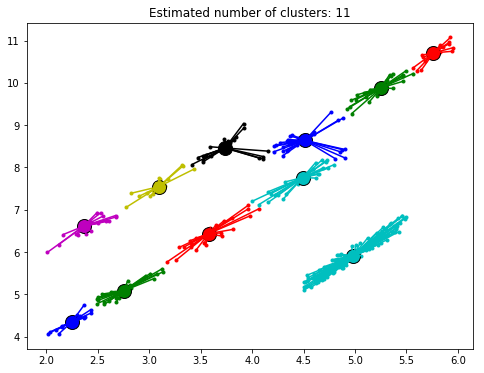

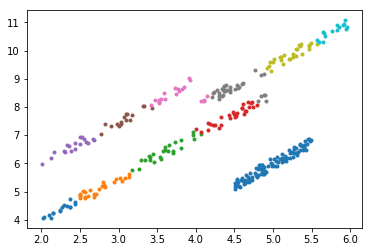

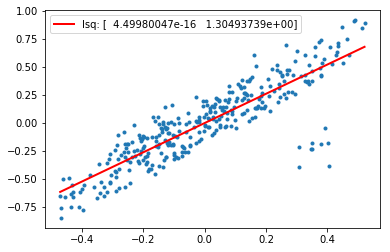

In [5]:
# Our example:
#
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
#                            random_state=0)
#
##############################################################################
# Compute Affinity Propagation
#af = AffinityPropagation(preference=-50).fit(XY)
X = numpy.array(XY)

af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# the predictive analyits don't seem to work prperly because we get the 'wrong' number of
# _true and _predicted clusters. dunno...
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

##############################################################################
# Plot result

plt.close('all')
plt.figure(1, figsize=(8,6))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    #
    for x in X[class_members]:
        # draw centroid 'edges'
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, ls='-')

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


####
min_clust_size=10
my_clusters = [[] for _ in list(set(labels))]  # could also be a dict with the index stated explicitly.
for k_index, xy in zip(labels, X):
    my_clusters[k_index] += [xy]
my_clusters = [clust for clust in my_clusters if len(clust)>=min_clust_size]
#
plt.figure()
for cl in my_clusters:
    plt.plot(*zip(*cl), marker='.', ls='')

XY_prime = cluster_tools.stack_clusters(my_clusters)
lsq = numpy.linalg.lstsq([[1., x] for x,y in XY_prime], [y for x,y in XY_prime])
#
plt.figure()
ax=plt.gca()
ax.plot(*zip(*XY_prime), marker='.', ls='')
my_X = numpy.linspace(min([x for x,y in XY_prime]), max([x for x,y in XY_prime]), 100)
ax.plot(my_X, f_lin(my_X,*lsq[0]), 'r-', lw=2., label='lsq: {}'.format(lsq[0]))
plt.legend(loc=0)



In [6]:
#print(labels)
k=2
c_m = labels==k
print(c_m)

print(X[c_m,0], X[c_m,1])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


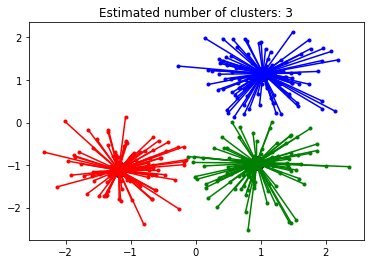

In [7]:
# Example in a Can:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

##############################################################################

# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

##############################################################################
# Plot result


plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [8]:
print('lt: ', labels_true)

lt:  [0 1 1 0 0 1 2 2 1 0 2 0 0 2 0 2 2 2 2 2 0 0 0 0 2 0 2 1 2 1 1 2 0 1 2 1 1
 1 1 0 0 0 2 0 1 2 2 2 2 0 0 0 2 1 1 1 1 0 1 0 2 1 1 2 2 2 2 0 1 0 1 2 0 0
 2 2 1 1 0 2 1 0 2 1 1 0 0 1 2 0 1 0 1 0 1 0 1 2 0 2 0 0 2 0 0 1 1 2 1 1 1
 1 1 2 0 1 2 2 1 2 1 1 1 1 1 1 0 2 2 2 0 2 2 1 0 1 0 2 1 0 2 2 2 0 2 0 1 2
 2 1 1 0 0 0 1 0 1 0 0 0 0 2 1 0 2 2 2 1 0 0 0 2 2 0 0 0 0 2 2 0 2 0 0 1 2
 0 1 2 0 1 1 1 0 2 1 2 0 2 0 2 0 0 2 1 1 1 1 0 2 2 0 1 1 1 0 2 0 0 2 0 1 1
 0 1 2 2 2 0 0 1 2 2 2 1 2 0 1 1 0 1 1 2 0 1 2 0 0 2 0 2 2 2 1 0 2 2 0 1 1
 1 1 0 0 0 0 0 2 2 1 0 0 1 1 1 2 1 2 1 1 2 2 2 1 2 0 2 1 0 2 1 1 2 1 1 1 2
 0 1 2 2]


## More likely candidates:
  - SpectralClustering
     - looks good from the output pictures, but it may require an n_clusters input (it's technically optinal)
     - one approach might be to do a cascade of SC(n) and pick the configureation that minimizes the stacked chi-square?
     - i think this algorithm, by design and typical application, is usually targeted toward image parsing applications.
  - AgglomerativeClustering
  - Ward (i think a sub-class of Agglomerative)
  - DBSCAN

### SpectralClustering:
note: this example is a bit differen than some of the other examples. we use the SpectralClustering class directly. i've seen some other examples that use some sort of spectral_clustering() class or function that appears maybe more suited towards image analysis.

/home/myoder/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


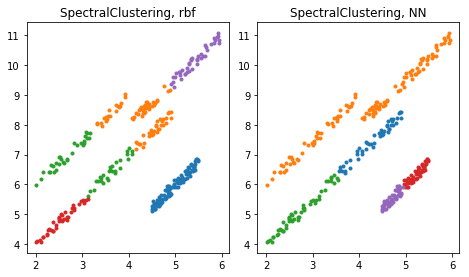

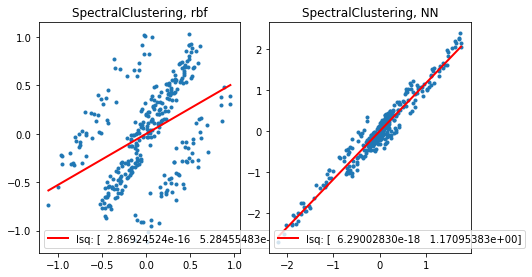

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
#
# options to consider (and i think these are the defaults):
# n_neighbors=10, n_clusters=8, n_init=10
# affinity='rbf' ... or {'nearest_neighbors', 'precomputed', or see }
#
n_clusters=5
#
sc_rbf = sklearn.cluster.SpectralClustering(n_clusters=n_clusters, affinity='rbf')
sc_nn = sklearn.cluster.SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
#sc_rbf.fit(XY)
#sc_nn.fit(XY)
#
lbls_rbf = sc_rbf.fit_predict(XY)
lbls_nn = sc_nn.fit_predict(XY)
#
clusters_rbf = cluster_tools.clusters_from_labels(XY,lbls_rbf)
clusters_nn = cluster_tools.clusters_from_labels(XY,lbls_nn)
#
fg  = plt.figure(figsize=(8,4))
ax1 = fg.add_axes([.1,.1,.35,.8])
ax1.set_title('SpectralClustering, rbf')
ax2 = fg.add_axes([.5,.1, .35, .8])
ax2.set_title('SpectralClustering, NN')
#
for cl in clusters_rbf:
    ax1.plot(*zip(*cl), marker='.', ls='')
for cl in clusters_nn:
    ax2.plot(*zip(*cl), marker='.', ls='')
#
XY_prime_rbf = cluster_tools.stack_clusters(clusters_rbf)
lsq_rbf = numpy.linalg.lstsq([[1.]+rw[:-1] for rw in XY_prime_rbf], [rw[-1] for rw in XY_prime_rbf])
#
XY_prime_nn = cluster_tools.stack_clusters(clusters_nn)
lsq_nn = optimizers.lsq_XY(XY_prime_nn)

fg  = plt.figure(figsize=(8,4))
ax1 = fg.add_axes([.1,.1,.35,.8])
ax1.set_title('SpectralClustering, rbf')
ax2 = fg.add_axes([.5,.1, .35, .8])
ax2.set_title('SpectralClustering, NN')
#
ax1.scatter(*zip(*XY_prime_rbf), marker='.')
X = numpy.array([min(XY_prime_rbf,key=lambda rw:rw[0])[0], max(XY_prime_rbf,key=lambda rw:rw[0])[0]])
#print(X)
ax1.plot(X, f_lin(X,*lsq_rbf[0]), color='r', lw=2., ls='-', label='lsq: {}'.format(lsq_rbf[0]))
#
ax2.scatter(*zip(*XY_prime_nn), marker='.')
X = numpy.array([min(XY_prime_nn,key=lambda rw:rw[0])[0], max(XY_prime_nn,key=lambda rw:rw[0])[0]])
#print(X)
ax2.plot(X, f_lin(X,*lsq_nn[0]), color='r', lw=2., ls='-', label='lsq: {}'.format(lsq_nn[0]))
#
for ax in (ax1, ax2):
    ax.legend(loc=0)

In [10]:
print(lsq_nn)

(array([  6.29002830e-18,   1.17095383e+00]), array([ 13.08036536]), 2, array([ 18.02775638,  13.15696766]))


In [11]:
DD = cluster_tools.get_Spectral_Clustering_analysis(XY,5, fignum=None)
print(DD['lsq'])
print(DD.keys())

[array([  4.54441473e-16,   1.20168154e+00]), array([ 14.17607612]), 2, array([ 18.02775638,   8.95932352]), [11.90973653153959]]
dict_keys(['clusters', 'stacked', 'lsq'])


/home/myoder/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [12]:
ns_clusters = [2,25]
#
lsq_ses = [cluster_tools.get_Spectral_Clustering_analysis(XY.copy(),n, hi=.9, lo=.1, lsq_metric_baseline_exponent=.5, 
                                                         fignum=None)['lsq'] for n in range(*ns_clusters)]

/home/myoder/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(11, 0.016128681026885913)


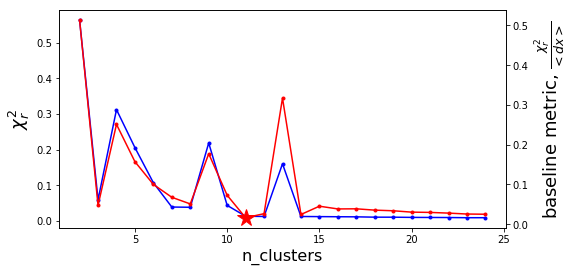

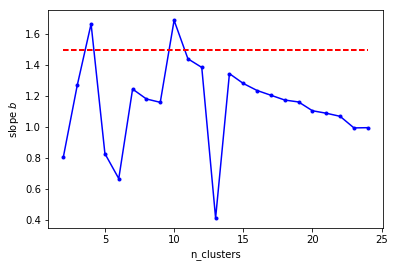

In [13]:
#lsq = get_Spectral_Clustering(XY, 2)
#print(lsq)
XY_fits = list(zip(range(*ns_clusters), [rw[-1][0]/(len(XY)-2) for rw in lsq_ses]))
plt.figure(figsize=(8,4))
ax1=plt.subplot(111)
#ax1=plt.gca()
ax2=ax1.twinx()
#ax3 = plt.subplot(122)
ax1.plot(range(*ns_clusters), [rw[1][0]/(len(XY)-2) for rw in lsq_ses], marker='.', ls='-', color='b')
ax1.set_ylabel('$\\chi^2_r$', size=18)
ax2.plot(*zip(*XY_fits), marker='.', ls='-', color='r')
ax2.plot(*zip(*numpy.atleast_2d(min(XY_fits, key=lambda rw: rw[1]))), marker='*', color='r', ms=18)
ax2.set_ylabel('baseline metric, $\\frac{\\chi^2_r}{<dx>}$', size=18)
ax1.set_xlabel('n_clusters', size=16)
#
plt.figure()
ax3=plt.gca()
ax3.plot(range(*ns_clusters), [rw[0][1] for rw in lsq_ses], marker='.', ls='-', color='b')
plt.plot(range(*ns_clusters), [b for _ in range(*ns_clusters)], ls='--', marker='', lw=2., color='r')
ax3.set_xlabel('n_clusters')
ax3.set_ylabel('slope $b$')
print(min(XY_fits, key=lambda rw:rw[1]))
#

### Ward:

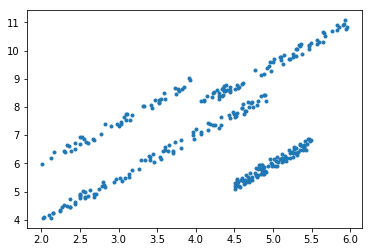

In [14]:
plt.figure()
plt.plot(*zip(*XY), marker='.', ls='')

** 2


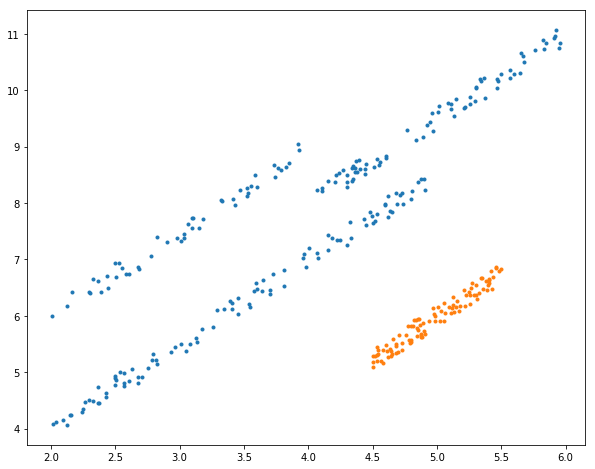

In [15]:
# it looks like there is some fault tolearance to throw out totally bogus eps={max_neighbor_range} inputs.
#sk_DB = sklearn.cluster.DBSCAN(eps=.3)
sk_DB = sklearn.cluster.DBSCAN()
lbls = sk_DB.fit_predict(XY)
clusts = cluster_tools.clusters_from_labels(XY,lbls)
print('**', len(clusts))

plt.figure(figsize=(10,8))
for cl in clusts:
    plt.plot(*zip(*cl), marker='.', ls='')

** 1


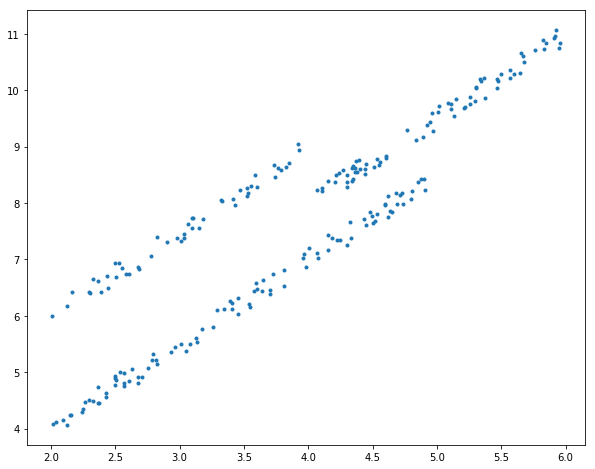

In [16]:
clusts2 = cluster_tools.get_sklearn_clustering(clusts[0], clust_class=sklearn.cluster.DBSCAN)
X = clusts[0]
#
plt.figure(figsize=(10,8))
for cl in clusts2:
    plt.plot(*zip(*cl), marker='.', ls='')
print('**', len(clusts2))

### Agglometerative Clustering
- This algorithm appears to be matureing a bit
- linkage='ward' is default

** 5


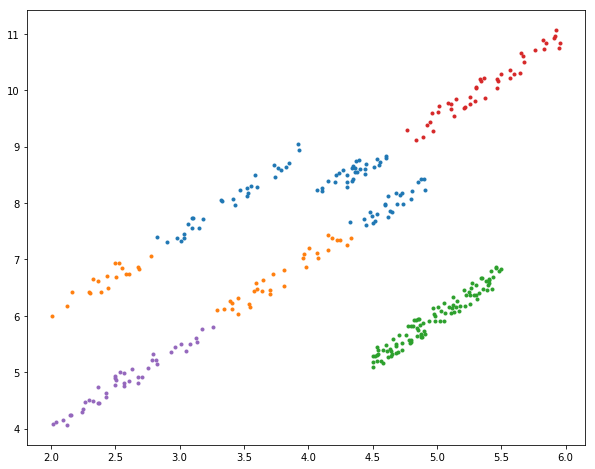

In [17]:
#sk_DB = sklearn.cluster.AgglomerativeClustering(n_clusters=2)
#
sk = sklearn.cluster.AgglomerativeClustering(n_clusters=5)
lbls = sk.fit_predict(XY)
clusts = cluster_tools.clusters_from_labels(XY,lbls)
#
plt.figure(figsize=(10,8))
for cl in clusts:
    plt.plot(*zip(*cl), marker='.', ls='')
print('**', len(clusts))


** 3


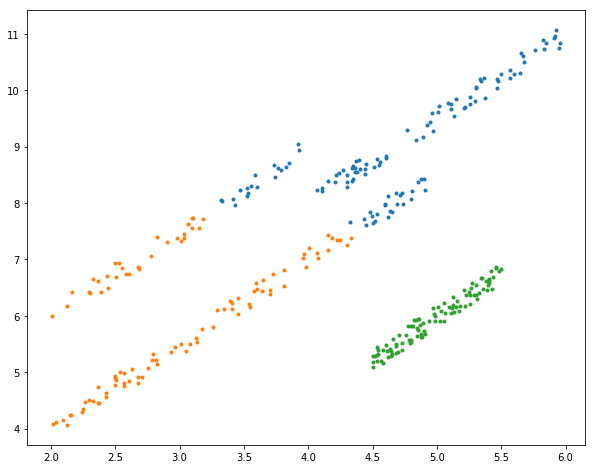

In [18]:
#sk_DB = sklearn.cluster.AgglomerativeClustering(n_clusters=2)
#
clusts = cluster_tools.get_sklearn_clustering(XY, clust_class=sklearn.cluster.Birch, threshold=.1)
plt.figure(figsize=(10,8))
for cl in clusts:
    plt.plot(*zip(*cl), marker='.', ls='')
print('**', len(clusts))


** 3


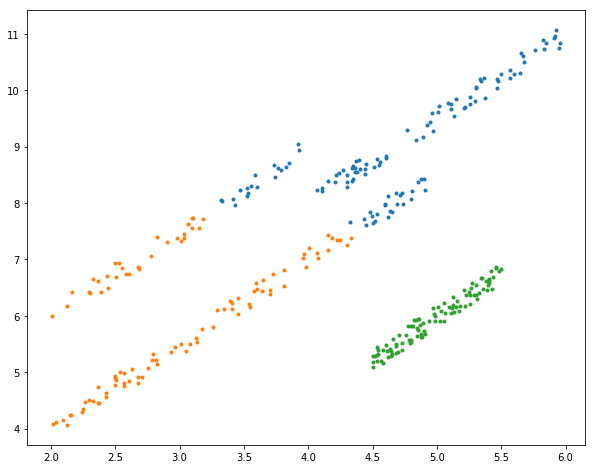

In [19]:
#sk_DB = sklearn.cluster.AgglomerativeClustering(n_clusters=2)
#
# this one is different...
#
sk = sklearn.cluster.FeatureAgglomeration()
lbls = sk.fit_transform(XY)
#
plt.figure(figsize=(10,8))
#
for cl in clusts:
    plt.plot(*zip(*cl), marker='.', ls='')
print('**', len(clusts))

### NN PCA vectors
- this probably has a name. the basic strategy is to find local linearity and nominally a scale with maximum linearity
- in this case, "linearity" means "long and skinny, like a line," as will become more clear below.
- Basically:
  - for some range $2 < k_{nn} < k_{max}$, get nearest-k-neighbor groups for each point in the data set
    - alternatively, get nn groups for some sampling of the space. this sampling might end up being one of the pre-processing steps.
  - calculate the nn vectors for each group (aka, the vector between each seed point and it's nn members
  - calculate PCA from these vectors. there is probably a proper name for this; get the eigen-values and vectors of the NN group/pairs. nominally, the vectors could also be weighted by nn-order. they will more or less auto-weight based on length.
     - aka, we can 'normalize' the distances by dividing each vector by sqrt(n) in each group.
  - linearity metric:
     - in 2D: ratio of eigen-values ($\lambda_{big}/\lambda_{small})$
     - for D>2: it depends, but a reasonable extension is $\lambda_{big}/(\sum{\lambda_j})$, where $\lambda_{j>0}$ are the smaller eigenvalues.
     
     

In [20]:
import sklearn.decomposition as skdp

#my_pca = skdp.PCA()
#my_pca.fit(XY)
#
#my_pca.get_covariance()
#
n_cpu=1
k_nn = 10
sk_nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_nn, radius=1, n_jobs=n_cpu)
#
# in principle, seeds are not subsets from nodes...
nodes = XY.copy()
seeds = XY.copy()
#
# now, we need some tuning parameters. let's learn about our NN pairs. what is the distribution
# of NN distances, etc. we will use this to determine when a cluster ends... and other stuff.
sk_nbrs.fit(nodes)
nn_distances, nn_indices = sk_nbrs.kneighbors(seeds, return_distance=True)
#
# if we want to normalize by nn order k (assuming a random walk model), it would look like this:
print(nn_distances[0])
print([x/numpy.sqrt(j+1) for j,x in enumerate(nn_distances[0])])
#
print(nn_indices[0:3])
#
# now, make a matrix of nn_distances
nn_vectors = []
for k, (xy_seed, ks_nn) in enumerate(zip(seeds, nn_indices)):
    # there will be one row for each seed input.\
    #xy_seed = seeds[k]
    nn_vectors += [numpy.array(nodes[j]) - numpy.array(xy_seed) for j in ks_nn]

#nn_vectors = [(numpy.array(nodes[j]) - numpy.array(xy_seed)) for k, (xy_seed, ks_nn) 
#              in enumerate(zip(seeds, nn_indices))  for j in ks_nn] 

nn_vectors = [(numpy.array(nodes[j]) - numpy.array(xy_seed))/((1 if not n_j==1 else n_j)**.5) for k, (xy_seed, ks_nn) 
              in enumerate(zip(seeds, nn_indices))  for n_j, j in enumerate(ks_nn)] 


# expanded for clarity:
# for k, (xy_seed, ks_nn) in enumerate(zip(seeds, nn_indices)):
#     # there will be one row for each seed input.\
#     #xy_seed = seeds[k]
#     nn_vectors += [numpy.array(nodes[j]) - numpy.array(xy_seed) for j in ks_nn]
#
# now, get the (normalized) covariance matrix:
cov = numpy.cov(numpy.transpose(nn_vectors))
print(cov)
# note: eigh, i think, assumes hermitian matrix; eig() is more robust, but slower and can make some
# complex-number errors.
eig_vals, eig_vecs = numpy.linalg.eigh(cov)
print('ex, ev: ', eig_vals, eig_vecs)
#
# now, the linearity metric:
ev_sorted = sorted(eig_vals)
ev_ratio = ev_sorted[0]/numpy.sum(ev_sorted[1:])
print('ev_ratio: ', ev_ratio)
#
ev_basis_vectors = list(zip(eig_vals, [*zip(*eig_vecs)]))

print('ev_basis: ')


[ 0.          0.04506864  0.10377276  0.11020094  0.21527608  0.21902705
  0.3177236   0.35285846  0.45988207  0.51009376]
[0.0, 0.031868338077670692, 0.059913231049331994, 0.0551004718718235, 0.096274389594551604, 0.08941742019111569, 0.12008823387799687, 0.12475430344659003, 0.15329402253974642, 0.16130581019148749]
[[ 0  1  3  2  5  4  6  7  8 11]
 [ 1  0  2  3  5  4  6  7  8 11]
 [ 2  1  3  5  0  4  6  7  8 11]]
[[ 0.01065841  0.00675339]
 [ 0.00675339  0.01674428]]
ex, ev:  [ 0.00629408  0.02110862] [[-0.83988203  0.542769  ]
 [ 0.542769    0.83988203]]
ev_ratio:  0.298175632028
ev_basis: 


v:  [ 3.37618367  7.63143248] [-0.83988203  0.542769  ]
v:  [ 4.75883469  7.92854551] [ 0.542769    0.83988203]


(1, 10)

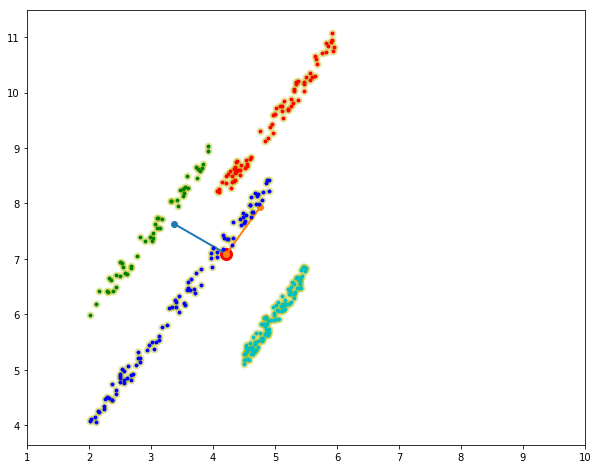

In [24]:
# what do we have so far?

plt.figure(figsize=(10,8))
ax1=plt.gca()
for j,c in enumerate(clusters_input):
    #
    ax1.scatter(*zip(*c), marker='.', color=colors_[j%len(colors_)], zorder=5)
    #
ax1.scatter(*zip(*XY), marker='o', alpha=.3, zorder=1, s=50, color='y')
#
xy0 = numpy.array([numpy.mean(col) for col in zip(*XY)])
plt.plot(*xy0, marker='o', ls='', color='r', ms=12)
#
for vc in numpy.transpose(eig_vecs):
#for vc in eig_vecs:
    v = xy0 + numpy.array(vc)
    #v = numpy.append(v,vc)
    print('v: ', v, vc)
    plt.plot(*zip(*(xy0, list(v))), ls='-', lw=2., marker='o')
    #
    #plt.plot([xy0[0], v[0]], [xy0[1], v[1]], ls='-', lw=2., marker='o')
ax=plt.gca()
ax.set_xlim(1,10)

In [25]:
print(eig_vecs)

[[-0.83988203  0.542769  ]
 [ 0.542769    0.83988203]]


In [26]:
print(eig_vecs[1][0]/eig_vecs[0][0], eig_vecs[0][0]/eig_vecs[1][0])

-0.646244329868 -1.54740235818
